## Data preparation and visualization
The dataset must be prepared according to the following steps:

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
from matplotlib.colors import ListedColormap, Normalize

# Load power dataset
building_data_train = pd.read_csv("data/building_4_weather_1_train.csv", parse_dates=["timestamp"], index_col=["timestamp"])

# Load weather dataset
weather_data = pd.read_csv("data/weather_1.csv", parse_dates=["timestamp"], index_col=["timestamp"])

**1.1** Merge the different data sources (i.e. building consumption and weather) for both training and testing.

In [36]:
# Check for duplicate timestamps
print(f"Num of duplicated \"timestamp\" in weather_data: {weather_data.index.duplicated().sum()}")
print(f"Duplicated \"timestamp\" in weather_data:\n{weather_data[weather_data.index.duplicated()]}")
print()
print(f"Num of duplicated \"timestamp\" in building_data_train: {building_data_train.index.duplicated().sum()}")
print()

# There are:
# 1 duplicated "timestamp" in weather_data
# 0 duplicated "timestamp" in building_data_train

# Remove duplicated timestamps
weather_data = weather_data[~weather_data.index.duplicated()]

Num of duplicated "timestamp" in weather_data: 1
Duplicated "timestamp" in weather_data:
                     airTemperature
timestamp                          
2017-10-29 02:00:00            12.8

Num of duplicated "timestamp" in building_data_train: 0



In [37]:
# Check for missing timestamps
missing_timestamps_weather = pd.date_range(start=weather_data.index.min(), end=weather_data.index.max(), freq="H")
missing_timestamps_weather = missing_timestamps_weather.difference(weather_data.index)
print(f"Missing \"timestamp\" in weather_data:\n {missing_timestamps_weather}")
print()
missing_timestamps_building = pd.date_range(start=building_data_train.index.min(), end=building_data_train.index.max(), freq="H")
missing_timestamps_building = missing_timestamps_building.difference(building_data_train.index)
print(f"Missing \"timestamp\" in building_data_train:\n {missing_timestamps_building}")
print()

# There are:
# 1 missing "timestamp" in weather_data
# 0 missing "timestamp" in building_data_train

# Fill missing timestamps
weather_data = weather_data.asfreq('H',method='ffill')

Missing "timestamp" in weather_data:
 DatetimeIndex(['2017-03-26 02:00:00'], dtype='datetime64[ns]', freq=None)

Missing "timestamp" in building_data_train:
 DatetimeIndex([], dtype='datetime64[ns]', freq='H')



In [38]:
# Now that we know that the index ("timestamp") are fixed we can merge the datasets

# Merge the energy and temperature datasets
data = building_data_train.join(weather_data, how='inner')

**1.2** _Identification of statistical outliers_: statistical outliers should be identified (if they exists) according to one of the methods analyzed during the course and removed for both the training and testing dataset.

Number of outliers detected with Z-score method: 66


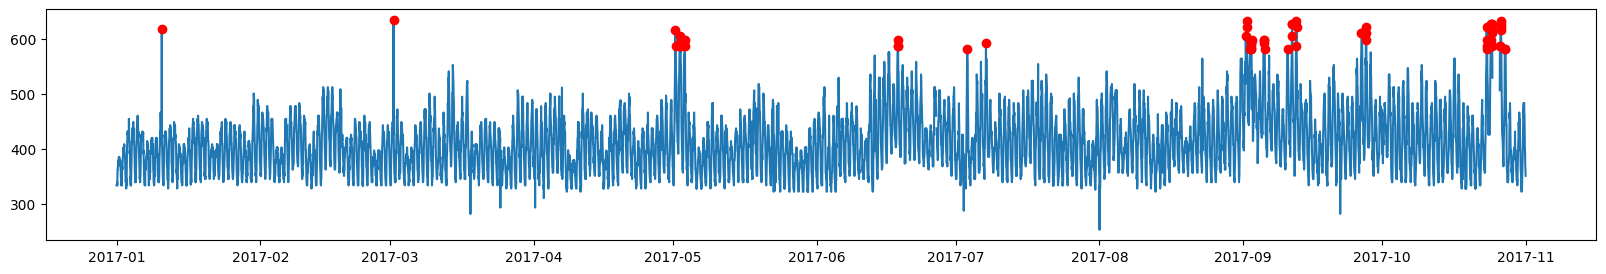

In [39]:
# Outlier detection: Z-score method

z_scores = (data['power'] - data['power'].mean()) / data['power'].std()
std_limit = 3
outliers_z_score = data['power'][(z_scores > std_limit) | (z_scores < -std_limit)]

print(f"Number of outliers detected with Z-score method: {len(outliers_z_score)}")

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(data['power'])
ax.plot(outliers_z_score.index, data.loc[outliers_z_score.index, 'power'], 'ro')

Number of outliers detected with interquartile method: 123


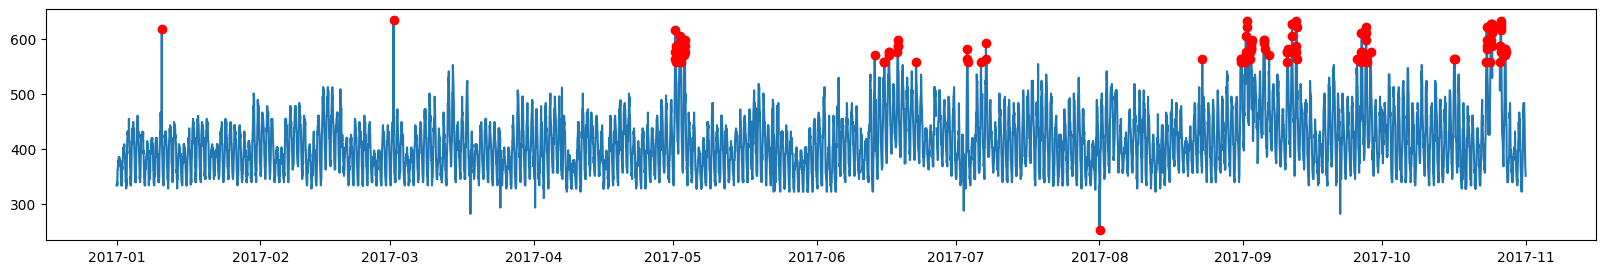

In [40]:
# Outlier detection: interquartile (or boxplot) method

Q1 = data['power'].quantile(0.25)
Q3 = data['power'].quantile(0.75)
IQR = Q3 - Q1
IQR_limit = 1.5

outliers_interquartile = data['power'][(data['power'] < Q1 - IQR_limit*IQR) | (data['power'] > Q3 + IQR_limit*IQR)]

print(f"Number of outliers detected with interquartile method: {len(outliers_interquartile)}")

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(data['power'])
ax.plot(outliers_interquartile.index, data.loc[outliers_interquartile.index, 'power'], 'ro')

In [41]:
# TODO: Outlier deletion

# def replace_outliers_na(data, column, multiplier=1.5):
#     # Calculate the first and third quartiles (Q1 and Q3)
#     Q1 = data[column].quantile(0.25)
#     Q3 = data[column].quantile(0.75)
    
#     # Calculate the IQR
#     IQR = Q3 - Q1
    
#     # Calculate the lower and upper bounds for outliers
#     lower_bound = Q1 - multiplier * IQR
#     upper_bound = Q3 + multiplier * IQR
    
#     # Filter the dataset to remove the outliers
#     mask = (data[column] < lower_bound) | (data[column] > upper_bound)
#     data.loc[mask, column] = np.nan

#     return data

#data = replace_outliers_na(data.copy(), 'power')

**1.3** _Missing values replacement_: missing values should be replaced according to one of the methods analyzed during the course for both training and testing set. Pay attention to not abuse of replacement methods. Avoid filling gaps larger than 3 timesteps.

In [42]:
# Check for null values of "power" and "airTemperature"
print(f"Num of null \"airTemperature\" data: {data['airTemperature'].isna().sum()}")
print()
print(f"Num of null \"power\" data: {data['power'].isna().sum()}")
data[data['power'].isna()]

# There are:
# 0 null "airTemperature" data
# 46 null "power" data

Num of null "airTemperature" data: 0

Num of null "power" data: 46


,power,airTemperature
timestamp,,
2017-03-12 02:00:00,NaN,10.6
2017-06-26 20:00:00,NaN,17.8
2017-09-01 16:00:00,NaN,36.7
2017-09-01 17:00:00,NaN,35.0
2017-09-01 18:00:00,NaN,32.2
2017-09-05 11:00:00,NaN,25.6
2017-09-05 12:00:00,NaN,26.7
2017-09-05 13:00:00,NaN,26.7
2017-10-08 14:00:00,NaN,25.0


In [43]:
# In this type of problem, when there is a NaN hole for 4/6/8 hours
# it is BETTER TO ELIMINATE THE DATA THAN INTERPOLATE.

# Delete the NaN "big" holes (2017-10-24, 2017-10-25, 2017-10-26)
data = data[ (data.index < "2017-10-24 00:00:00") | (data.index > "2017-10-26 23:59:00")]
print(f"Num of missing values in building_data_train: {data['power'].isna().sum()}")
data[data['power'].isna()]

Num of missing values in building_data_train: 9


,power,airTemperature
timestamp,,
2017-03-12 02:00:00,NaN,10.6
2017-06-26 20:00:00,NaN,17.8
2017-09-01 16:00:00,NaN,36.7
2017-09-01 17:00:00,NaN,35.0
2017-09-01 18:00:00,NaN,32.2
2017-09-05 11:00:00,NaN,25.6
2017-09-05 12:00:00,NaN,26.7
2017-09-05 13:00:00,NaN,26.7
2017-10-08 14:00:00,NaN,25.0


In [44]:
# Fill NaN "small" holes (max 3 hours in a row)
data['power'].interpolate(method='spline', limit=3, inplace=True, order=3)
print(f"Num of missing values in building_data_train: {data['power'].isna().sum()}")

Num of missing values in building_data_train: 0


**1.4** _Data visualization_: describe the time series data through different visualization techniques. Take inspiration from the different examples introduced during the course.

Text(0.5, 1.0, 'Electrical Load Time Series')

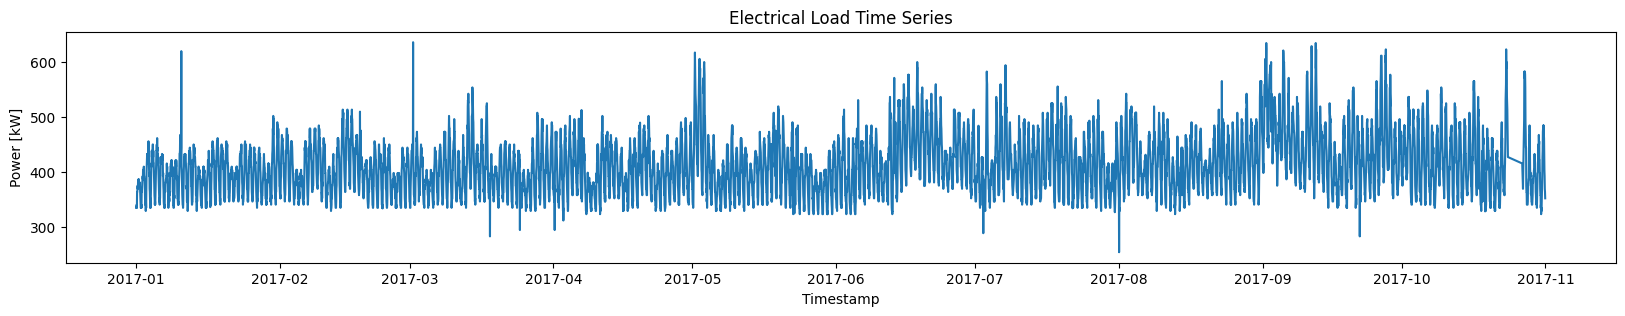

In [45]:
# Plot of "power" versus "timestamp"
dataResetIndex = data.reset_index()

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dataResetIndex["timestamp"], dataResetIndex["power"])
ax.set_xlabel("Timestamp")
ax.set_ylabel("Power [kW]")
ax.set_title("Electrical Load Time Series")

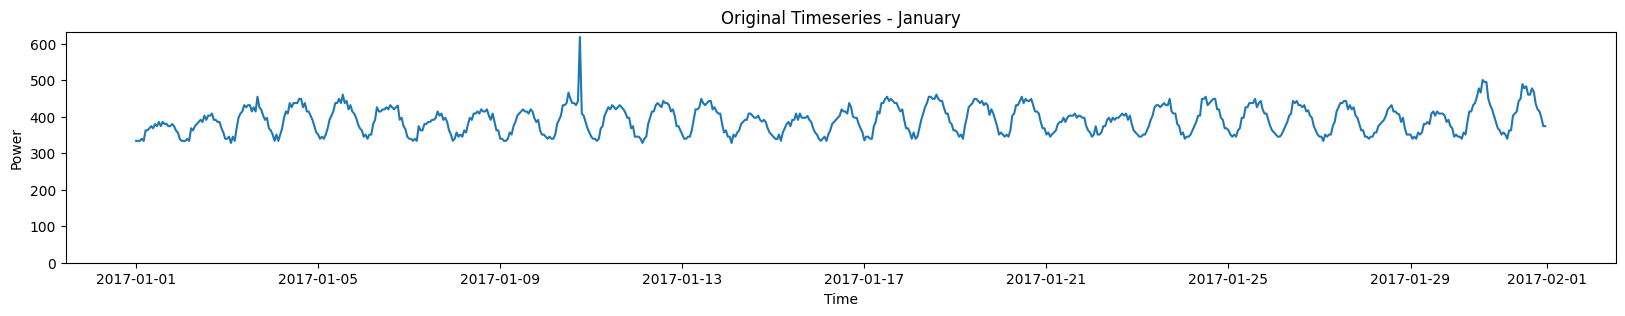

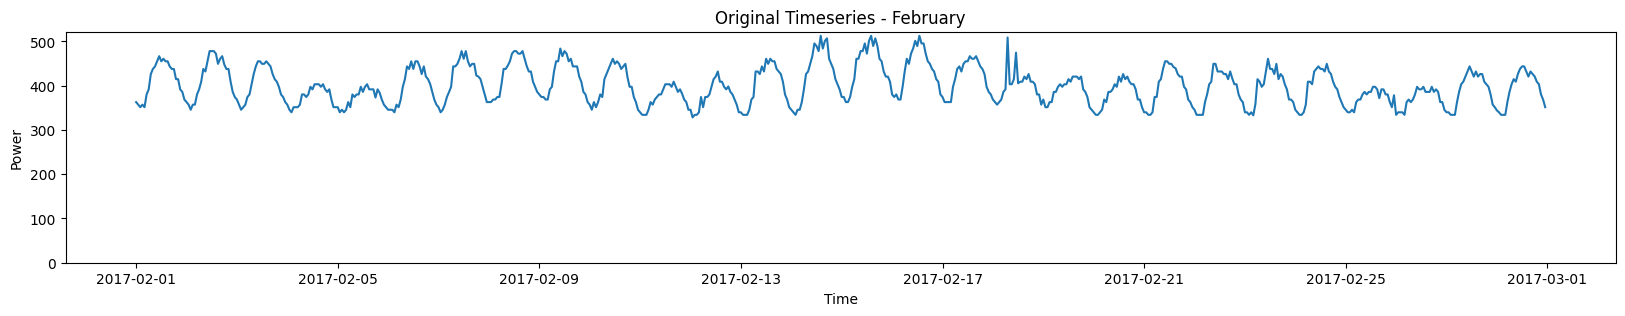

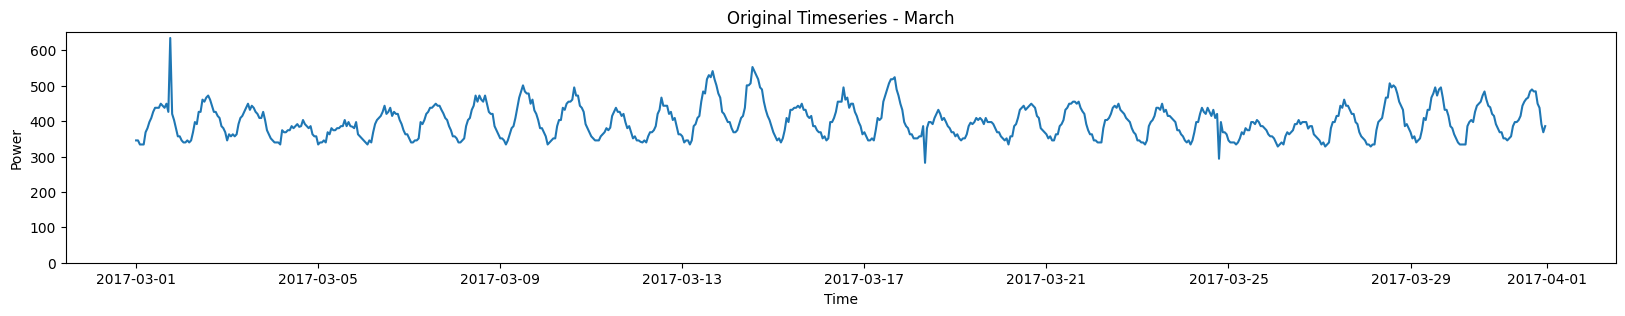

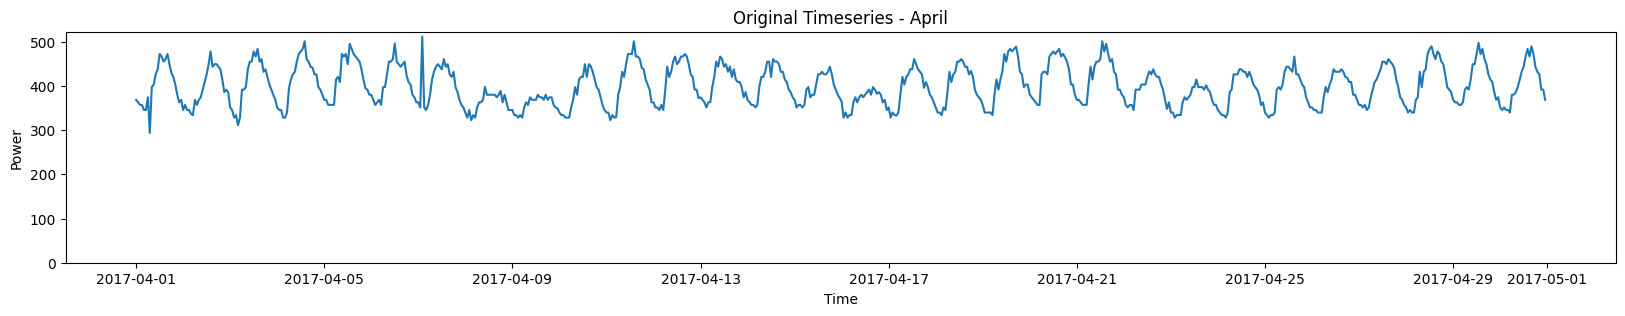

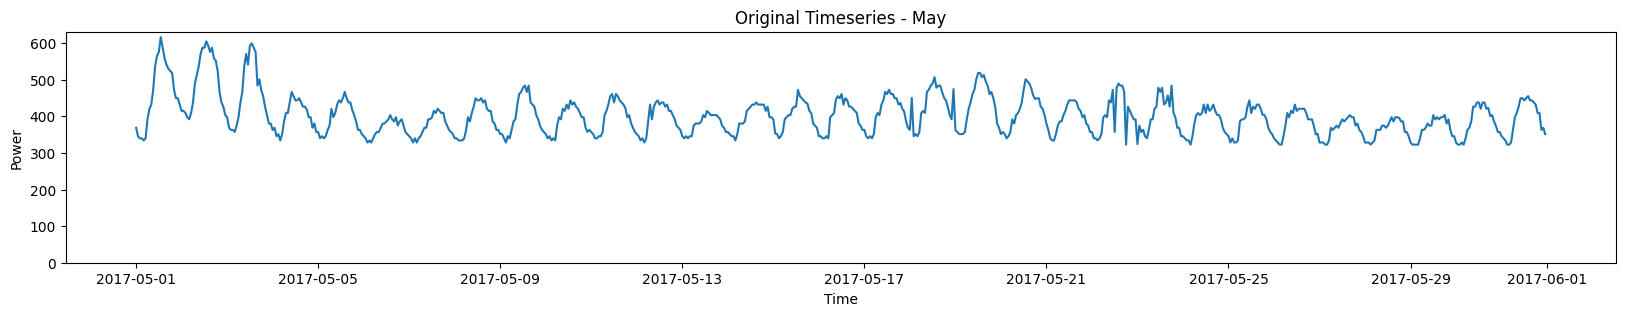

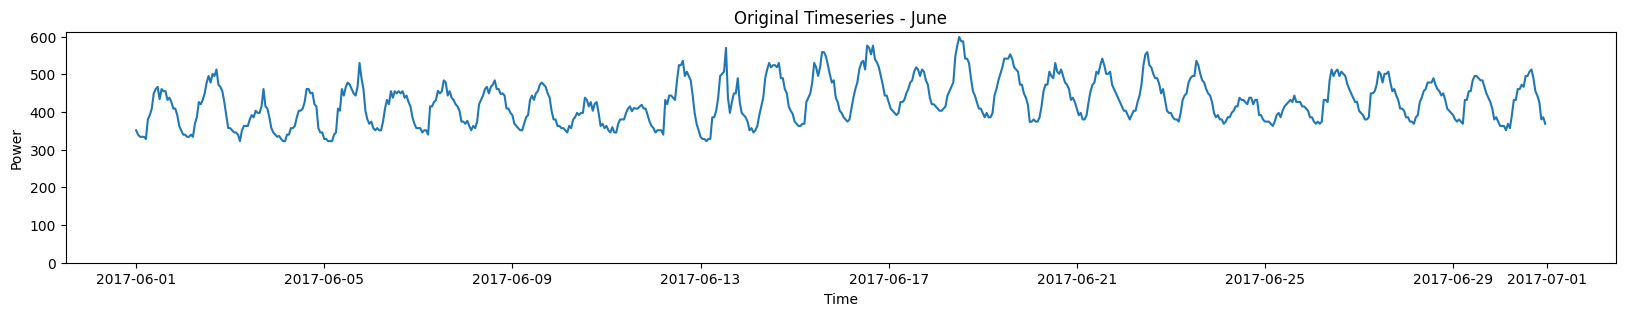

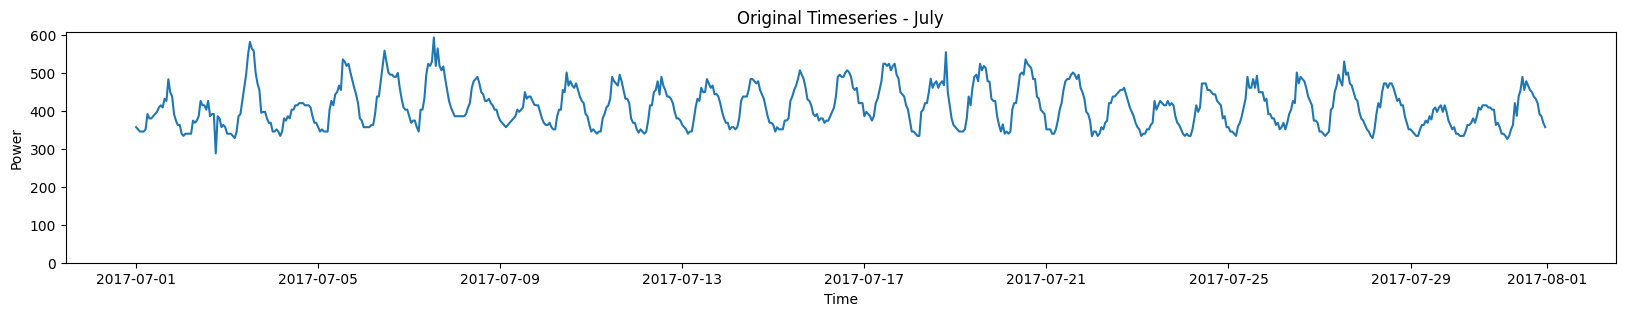

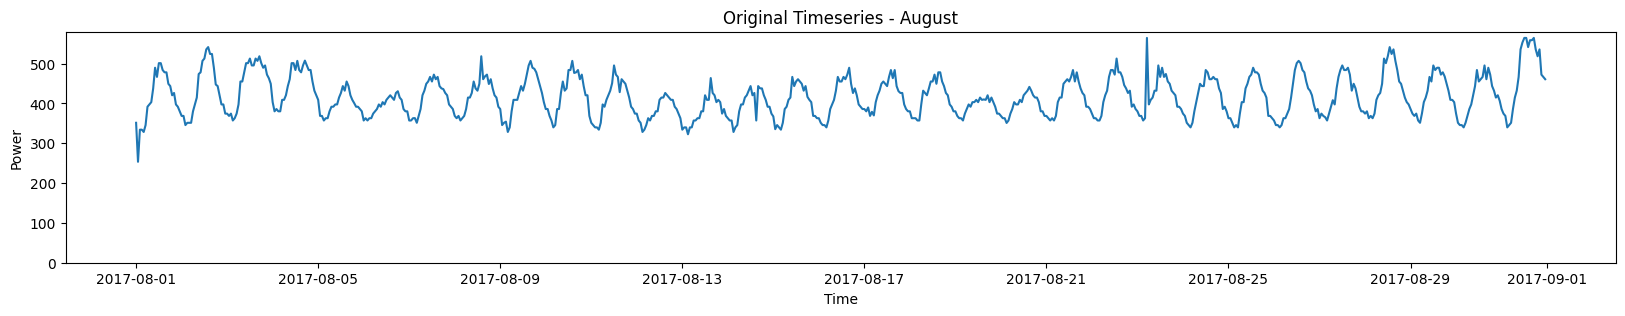

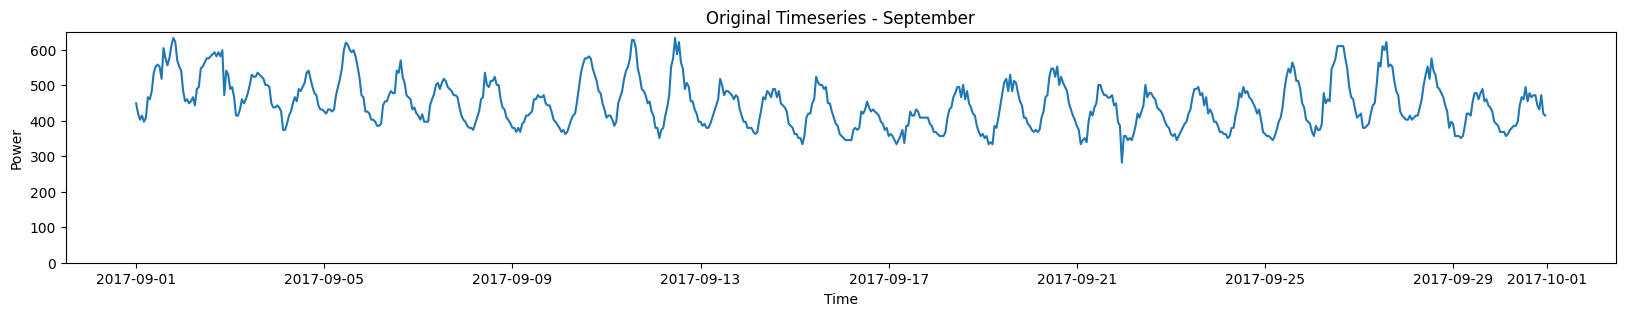

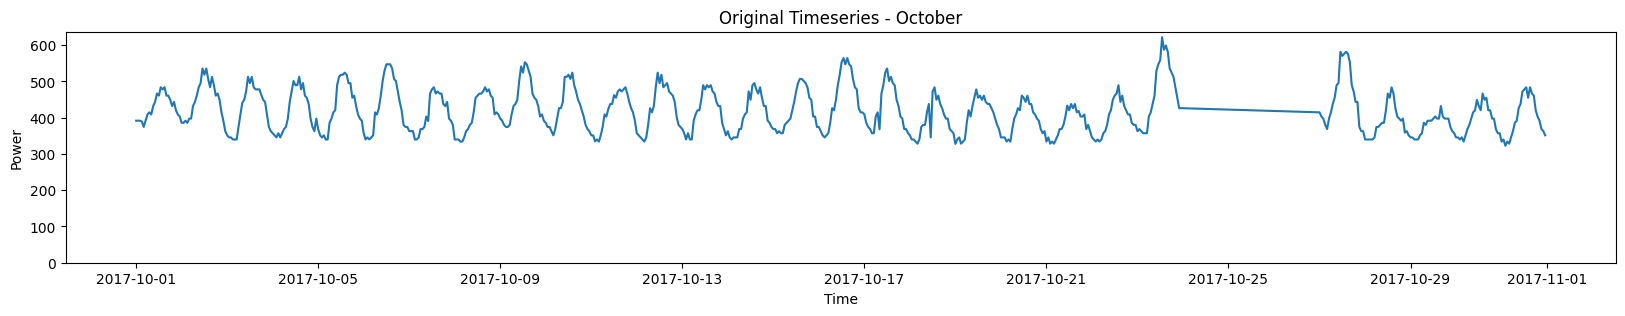

In [46]:
# Visualize original data subset by month
january = data.loc["2017-01-01 00:00:00":"2017-01-31 23:59:00"].reset_index()
february = data.loc["2017-02-01 00:00:00":"2017-02-28 23:59:00"].reset_index()
march = data.loc["2017-03-01 00:00:00":"2017-03-31 23:59:00"].reset_index()
april = data.loc["2017-04-01 00:00:00":"2017-04-30 23:59:00"].reset_index()
may = data.loc["2017-05-01 00:00:00":"2017-05-31 23:59:00"].reset_index()
june = data.loc["2017-06-01 00:00:00":"2017-06-30 23:59:00"].reset_index()
july = data.loc["2017-07-01 00:00:00":"2017-07-31 23:59:00"].reset_index()
august = data.loc["2017-08-01 00:00:00":"2017-08-31 23:59:00"].reset_index()
september = data.loc["2017-09-01 00:00:00":"2017-09-30 23:59:00"].reset_index()
october = data.loc["2017-10-01 00:00:00":"2017-10-31 23:59:00"].reset_index()

monthWithMissingValues = [march, june, september, october]
montWithNonMissingValues = [january, february, april, may, july, august,]
allMonths = [january, february, march, april, may, june, july, august, september, october ]

for month in allMonths:
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.plot(month['timestamp'], month['power'], label='Original')
    ax.set_title(f'Original Timeseries - {month["timestamp"][0].strftime("%B")}')
    ax.set_ylabel('Power')
    ax.set_xlabel('Time')
    ax.set_ylim([0, None])

Text(0.5, 0, 'Time')

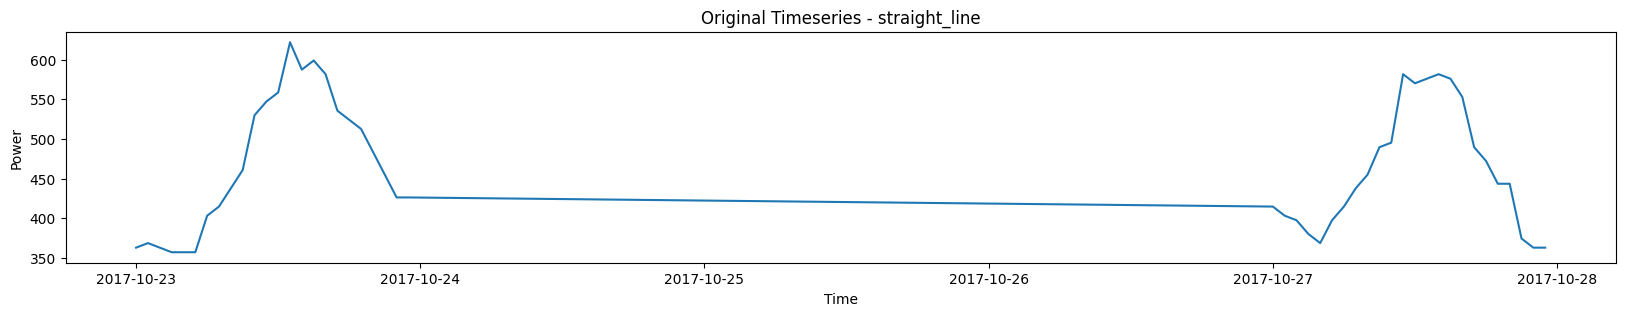

In [65]:
# from the previous plot we can see that there might be a problem with the data
# in the dates between "2017-10-23 00:00:00" and "2017-10-27 23:59:00"
straight_line = data.loc["2017-10-23 00:00:00":"2017-10-27 23:59:00"].reset_index()
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(straight_line['timestamp'], straight_line['power'], label='Original')
ax.set_title(f'Original Timeseries - straight_line')
ax.set_ylabel('Power')
ax.set_xlabel('Time')
ax.set_ylim([0, 700])

# TODO: Do we want to remove these data???

Text(120.72222222222221, 0.5, 'Date')

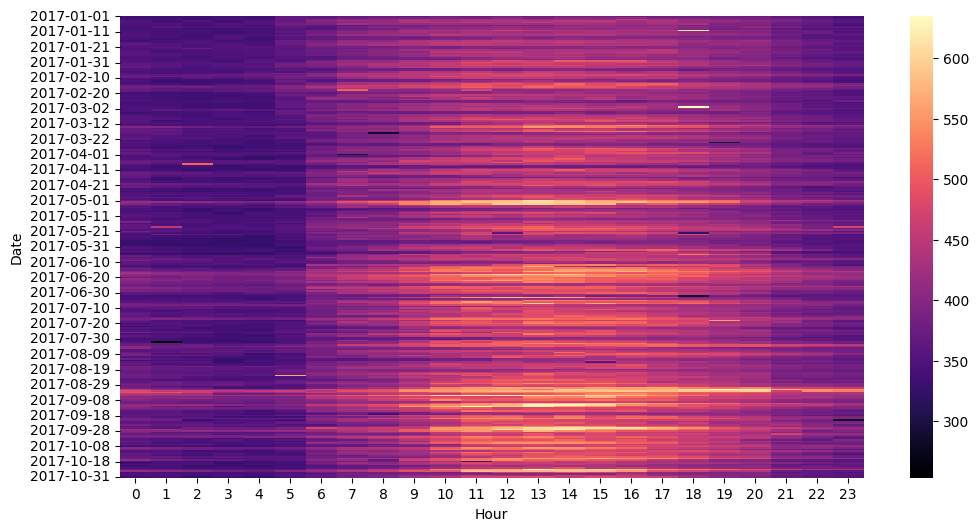

In [48]:
# Heatmap
dataResetIndex['hour'] = dataResetIndex['timestamp'].dt.hour
dataResetIndex['date'] = dataResetIndex['timestamp'].dt.date
df_pivot = dataResetIndex.pivot(index='date', columns='hour', values='power')

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df_pivot, cmap='magma', ax=ax)

# impostazione delle etichette degli assi
ax.set_xlabel('Hour')
ax.set_ylabel('Date')

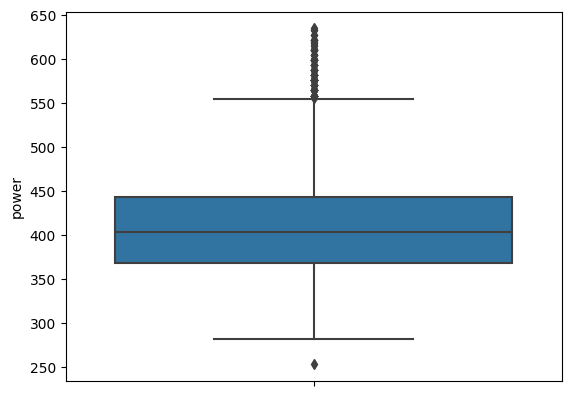

In [49]:
# Boxplot (total)
sns.boxplot(y="power", data=dataResetIndex)
plt.show()

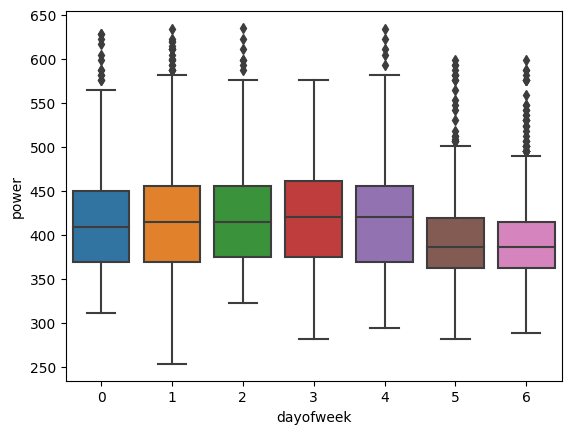

In [50]:
# Boxplot (day of the week)
dataResetIndex['dayofweek'] = dataResetIndex['timestamp'].dt.day_of_week

sns.boxplot(x='dayofweek', y="power", data=dataResetIndex)
plt.show()

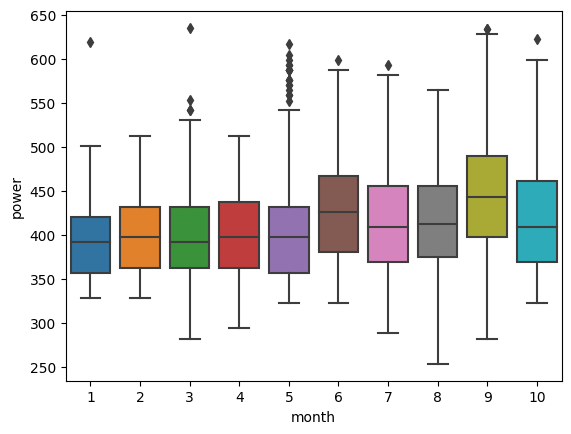

In [51]:
# Boxplot (month)
dataResetIndex['month'] = dataResetIndex['timestamp'].dt.month

sns.boxplot(x='month', y="power", data=dataResetIndex)
plt.show()

c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


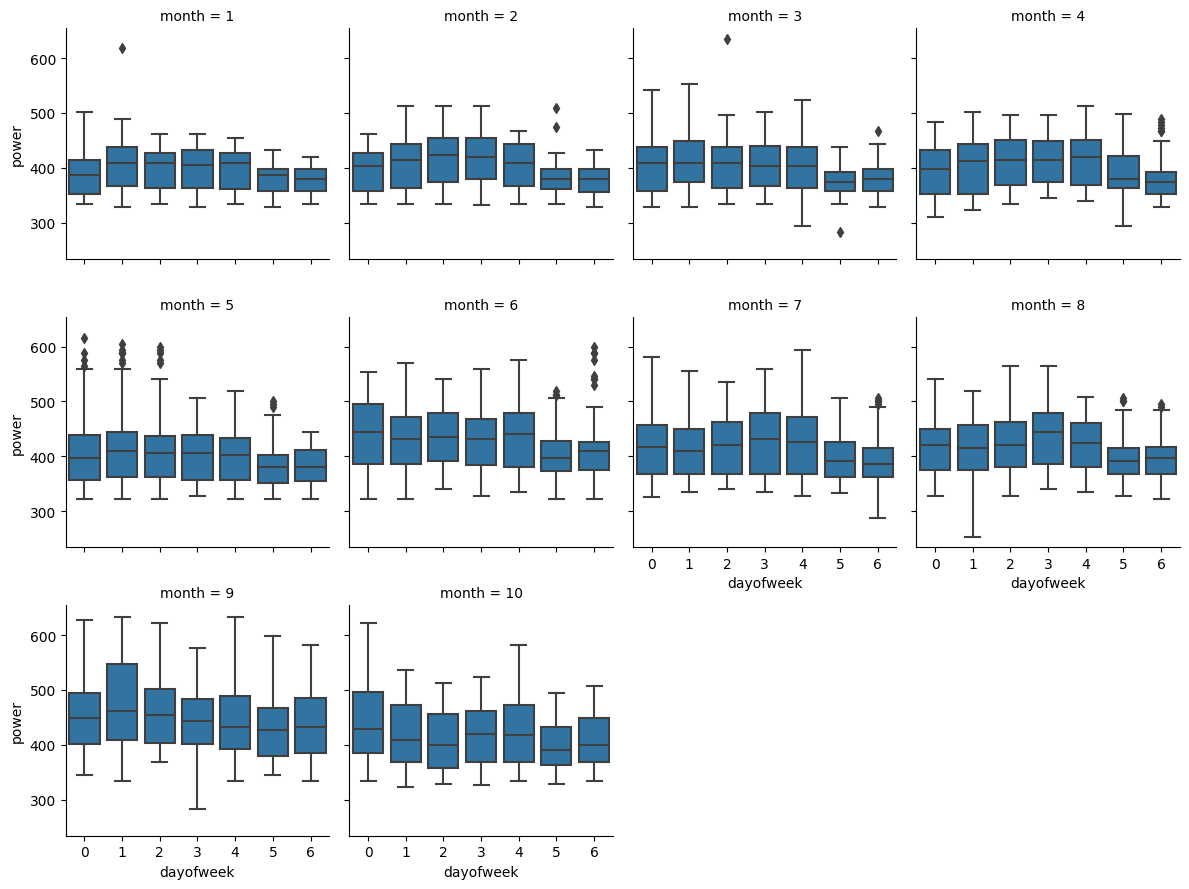

In [52]:
# Boxplot (day of the week per month)
g = sns.FacetGrid(dataResetIndex, col="month", col_wrap=4)
g.map(sns.boxplot, "dayofweek", "power")
plt.show()

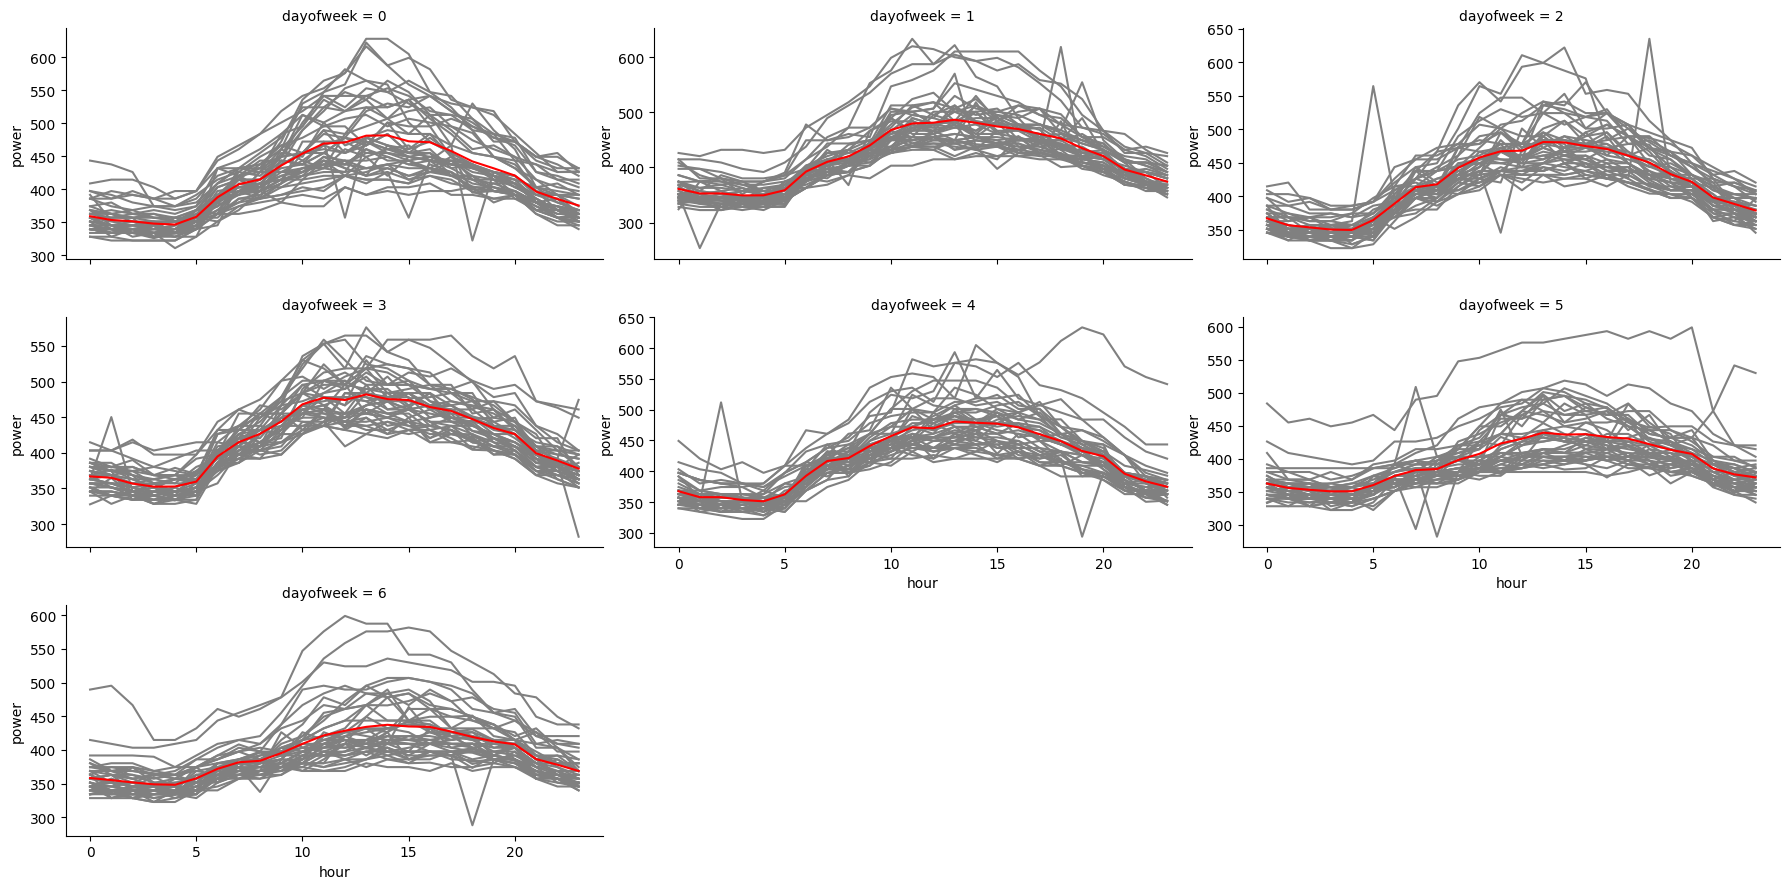

In [53]:
# Load profile (per day of the week)
dataResetIndex_mean = dataResetIndex.groupby(['dayofweek', 'hour'])['power'].mean().reset_index()
g = sns.FacetGrid(data=dataResetIndex, col='dayofweek', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

for ax, day in zip(g.axes.flatten(), dataResetIndex_mean['dayofweek'].unique()):
    sns.lineplot(x='hour', y='power', data=dataResetIndex_mean[dataResetIndex_mean['dayofweek'] == day], color='r', ax=ax, label='Profilo medio', legend=False)

plt.show()

In [54]:
# How is the average load profile?
# It is not representative of all profiles that fall into the same grouping. There is a lot of variability in the groupings: we have profiles ranging from 300 to 600 kW. 

# What analysis could we do to better group the load profiles?
# We can proceed with a clustering analysis of the load profiles.

## Load profiles characterization
Perform on the training dataset a load profile characterization process based on unsupervised clustering algorithms according to the following steps:

**2.1** _Dataset manipulation_: the training dataset should be organized into a MxN matrix to perform clustering according to one of the methods introduced during the course.

In [55]:
from sklearn.cluster import KMeans

# Feature engineering
# extract the date only from the timestamp only, not the time
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['date'] = data.index.date

df_matrix = data.pivot(index='date', columns='hour', values='power')



<Axes: xlabel='hour', ylabel='date'>

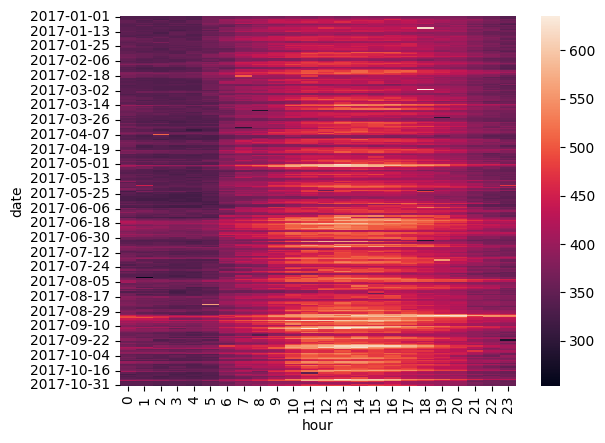

In [56]:
sns.heatmap(df_matrix)

**2.2** _Identification of the “best” clustering solution_: the “best” number of clusters should be identified according to both evaluation metrics (i.e. silhouette index and davies bouldin index) introduced during the course and personal considerations with respect to the results obtained.

In [57]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

K_range = [2, 3, 4, 5, 6, 7, 8]
db_list = []
sh_list = []

# write your code here
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
    labels = kmeans.labels_
    sh_list.append(silhouette_score(df_matrix, kmeans.labels_))
    db_list.append(davies_bouldin_score(df_matrix, kmeans.labels_))
    print(np.unique(labels, return_counts=True))
print(f"The best number of clusters according to Silhouette is {K_range[np.argmax(sh_list)]}")
print(f"The best number of clusters according to DB Index is {K_range[np.argmin(db_list)]}")

c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\

(array([0, 1]), array([ 77, 224], dtype=int64))
(array([0, 1, 2]), array([116,  46, 139], dtype=int64))
(array([0, 1, 2, 3]), array([ 44,  55, 103,  99], dtype=int64))
(array([0, 1, 2, 3, 4]), array([95, 94, 55, 16, 41], dtype=int64))
(array([0, 1, 2, 3, 4, 5]), array([89, 44, 16, 97,  2, 53], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([84, 55, 93, 14, 25,  2, 28], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([74, 25, 14, 28, 35,  2, 81, 42], dtype=int64))
The best number of clusters according to Silhouette is 2
The best number of clusters according to DB Index is 2


c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**2.3** _Data visualization and comment_: visualizations describing the solution obtained should be produced with a critical comment of the results

In [58]:
# Perform clustering
K = 4
kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
labels = kmeans.labels_
print(labels)
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts


[1 1 3 3 3 3 1 1 1 3 3 3 3 1 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 2 2 3 2 3 1 1 3
 2 2 2 3 1 1 3 2 2 2 2 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 2 2 1 3 2 0 3
 2 2 1 1 3 3 3 3 3 1 1 3 2 2 3 2 3 3 3 2 2 3 3 1 1 3 2 2 3 3 3 1 3 3 2 2 2
 3 1 3 3 3 3 2 2 2 0 0 0 3 3 1 1 3 3 3 3 3 1 3 3 3 2 2 2 2 3 3 3 3 3 1 1 1
 1 3 3 3 2 1 1 2 3 2 2 2 1 1 2 2 0 0 0 0 0 0 0 0 0 0 3 3 0 2 2 2 2 1 1 2 1
 2 0 0 2 3 2 2 3 2 2 2 2 0 2 2 2 2 3 1 3 2 2 2 3 1 1 3 2 2 0 0 3 1 2 2 2 2
 2 1 1 3 3 2 2 2 1 3 2 2 2 2 2 2 2 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 2 2 3
 1 2 2 0 2 2 2 2 0 0 0 0 2 2 2 0 2 2 2 0 2 2 0 2 2 2 2 2 2 0 2 3 3 3 1 3 0
 0 3 1 3 3]


c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3]), array([ 44,  55, 103,  99], dtype=int64))

In [59]:
data['cluster'] = np.repeat(labels, 24)

In [60]:
# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = data.groupby(['cluster', 'hour'])['power'].mean().reset_index()

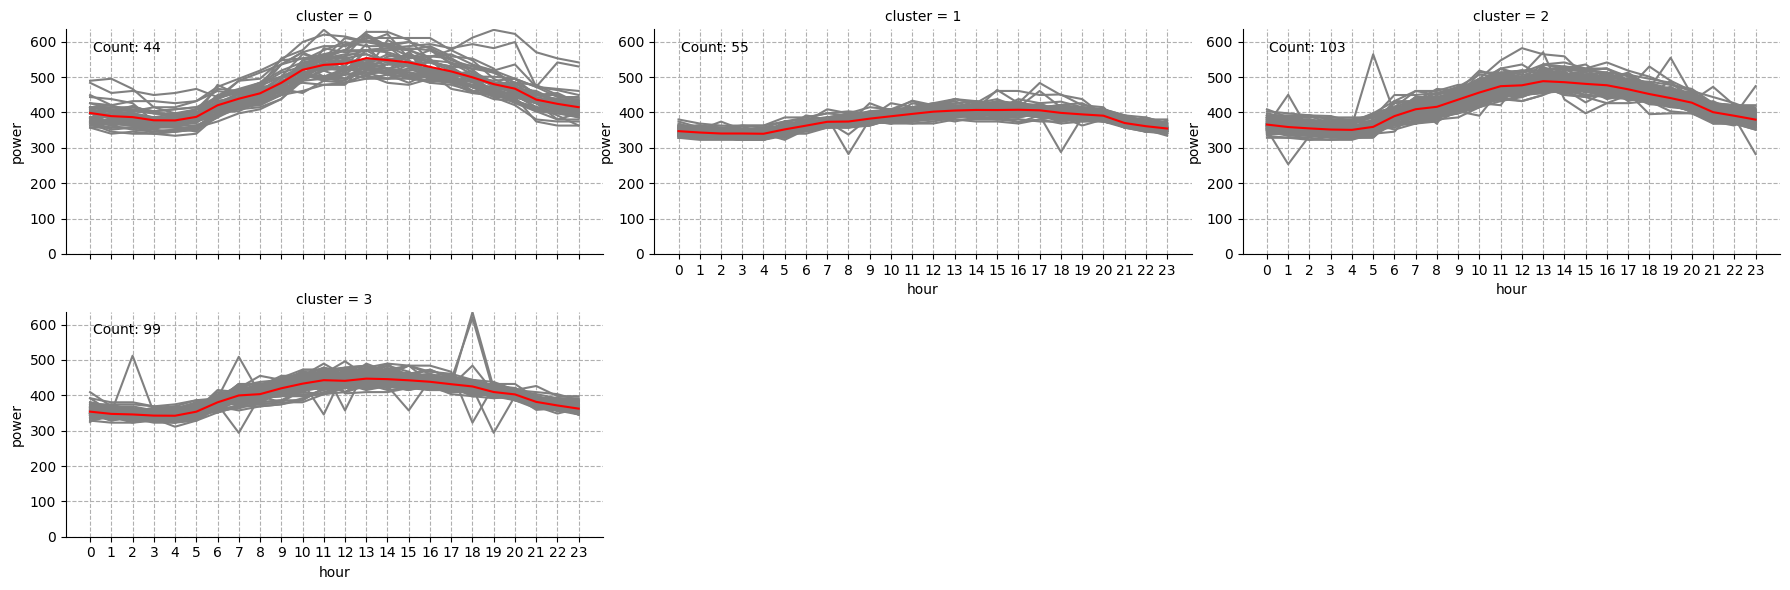

In [61]:
# generating load profiles
g = sns.FacetGrid(data=data, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=data['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1



plt.show()

c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\ITLUPAR5\Desktop\Luca_noSync\DataScience\Exam\data-science-and-ai-for-industrial-systems\.venv\Lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


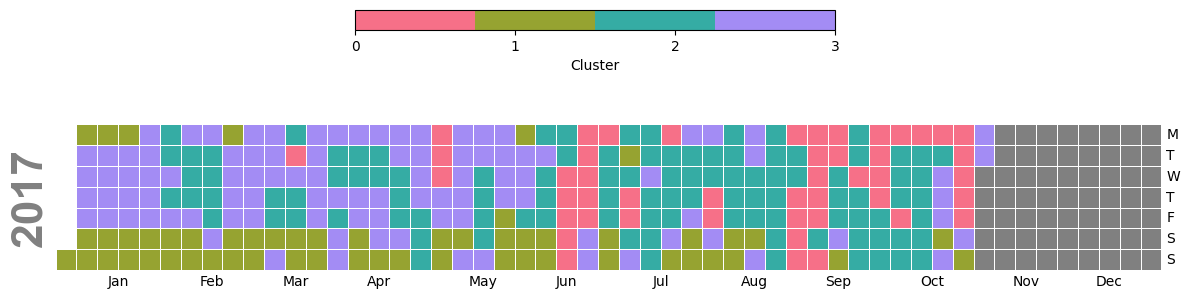

In [62]:
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))

# define colors accordin to palette
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(np.sort(cal_data['cluster'].unique()))
cb.set_ticklabels(np.sort(cal_data['cluster'].unique()))

plt.show()

#### Energy benchmarking model
Develop a regression model to perform a benchmarking process of energy consumption according to the following steps:

**3.1** _Input data selection_: according to the results of the load profile characterization phase the training set CAN be filtered removing records relative to load profiles representing infrequent or anomalous consumption patterns

**3.2** _Model training and selection_: a regression model based on one of the methods available in the scikit-library should be trained. Different methods of the scikit library can be tested (https://scikit-learn.org/stable/supervised_learning.html). If reputed necessary, hyperparameter tuning should be performed employing cross validation as introduced during the course

**3.3** _Performance evaluation_: the performance of the model should be evaluated using appropriate metrics, such as mean absolute error, and root mean square error

**3.3** _Model deployment_: the trained (and validated) model should be, applied to the testing dataset to estimate the energy consumption. The estimated energy consumption should be compared with the actual energy consumption to evaluate overconsumption and underconsumption as introduced during the course

**3.4** _Data visualization and comment_: visualizations describing the solution obtained should be produced with a critical comment of the results